### Comparing the performance of the updated models trained using 100k segments in 2018-Oct and 2018-April


In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:

from sklearn.datasets import load_svmlight_file
from sklearn.externals import joblib
import argparse
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report

In [5]:
result = pd.read_csv('~/all_2k_prediction.out.label.prediction_combined',sep=' ',header=None,names=['name','length','probability','prediction','vfam','pfam','diamond','label',
                                                                                       'score_euk_non_euk','pred_euk_non_euk','score_non_euk_virus','pred_non_euk_virus',
                                                                                      'score_virus_non_virus','pred_virus_non_virus'])

In [6]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()

In [7]:
### Using MEGAN annotation to check model performance 

def get_top_label(tax_id):
    try:
        lineage = ncbi.get_lineage(tax_id)
    except:
        return "N/A"
    for i in lineage:
        if i == 2759:
            return "Eukaryota"
        elif i == 10239:
            return "Virus"
        elif i == 2157:
            return "Archaea"
        elif i == 2:
            return "Bacteria"
        elif i == 12884:
            return "Viroids"
        elif i == 28384:
            return "other"
        elif i == 12908:
            return "unclassified"
    else:
        return "N/A"

def get_ranks(tax_id):
    ranks = ncbi.get_rank([tax_id])
    try:
        return ranks[tax_id]
    except:
        return tax_id
    
def get_name(tax_id):
    ranks = ncbi.get_taxid_translator([tax_id])
    try:
        return ranks[tax_id]
    except:
        return tax_id

# get MEGAN annotation results

megan_annot = pd.read_csv('./Micromonas/all_2k_contigs.fa.diamond-ex-all_tax_ID.txt',sep='\t',header=None,names=['name','tax_id'])

megan_annot['rank'] = megan_annot['tax_id'].apply(get_ranks)
megan_annot['tax_name']= megan_annot['tax_id'].apply(get_name)
megan_annot['top_label']= megan_annot['tax_id'].apply(get_top_label)


/global/homes/q/qpzhang/vica/miniconda/envs/vica/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 171193 was translated into 153265
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/global/homes/q/qpzhang/vica/miniconda/envs/vica/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 206350 was translated into 32003
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/global/homes/q/qpzhang/vica/miniconda/envs/vica/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 383630 was translated into 1660158
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


In [8]:
new_table = pd.merge(result,megan_annot, on=['name'])

In [9]:
prediction_new = pd.read_csv('/global/projectb/scratch/qpzhang/TARA/Libsvm/ViCA2/all_2k_contigs.fa.prediction.new1M')

In [10]:
prediction_old = pd.read_csv('/global/projectb/scratch/qpzhang/TARA/Libsvm/ViCA2/all_2k_contigs.fa.prediction.Adam')

In [11]:
prediction_new_subset = prediction_new[['ID','Prob_class_0']]

In [12]:
prediction_new_subset.rename(index=str,columns={"ID": "name"},inplace=True)

/global/homes/q/qpzhang/vica/miniconda/envs/vica/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [13]:
prediction_new_subset.rename(index=str,columns={"Prob_class_0": "new_prediction"},inplace=True)



In [14]:
prediction_old_subset = prediction_old[['ID','Prob_class_0']]

In [15]:
prediction_old_subset.rename(index=str,columns={"ID": "name"},inplace=True)

In [16]:
prediction_old_subset.rename(index=str,columns={"Prob_class_0": "old_prediction"},inplace=True)

In [17]:
new_table_old_joined = pd.merge(new_table,prediction_old_subset, how='left',on=['name'])

In [18]:
new_table_old_new_joined = pd.merge(new_table_old_joined,prediction_new_subset, how='left',on=['name'])

### 7041 contigs as ground-truth virus-related, with hits to virus-related domains, or annotated as virus by MEGAN based on BlastX/Diamond alignment

### 208302 contigs with length >=2k, in TARA


In [19]:
new_table_old_new_joined["non_euk_label"] = (new_table_old_new_joined.top_label!='Eukaryota')

In [20]:
new_table_old_new_joined["micromonas_label"] = (new_table_old_new_joined.tax_name=='Micromonas') |(new_table_old_new_joined.tax_name=='Micromonas pusilla CCMP1545')|(
        new_table_old_new_joined.tax_name=='Micromonas commoda')


#### "no rank" does not equal "no annotation"

In [21]:
def convert_top_label(top_label):
    if top_label == 'N/A':
        return 'no annotation'
    else:
        return 'with annotation'

In [22]:
new_table_old_new_joined['annotation_label'] = new_table_old_new_joined['top_label'].map(convert_top_label)

### Split the TARA contigs into 3 categories

- "Virus" has virus-related domain hits or annotated as "virus" by MEGAN
- "Non-virus" , no virus-related domain hits, annotated as some non-virus taxonomical group by MEGAN 
- "Unknown",  no virus-related domain hits, not annotated into any taxonomical group by MEGAN, top_label as "N/A"

#### subsample "non-virus" and "unknown" to have same number of "Virus" contigs - 6913

In [23]:
# "non-virus" data frame... non-virus and with annotation by MEGAN
df_nonvirus = new_table_old_new_joined[new_table_old_new_joined.label==0.0][new_table_old_new_joined['annotation_label']== 'with annotation']
df_nonvirus_subsample = df_nonvirus.sample(n=7041, replace=False)
#df_nonvirus_subsample.to_csv('df_nonvirus_subsample.csv')

# "Unknown" data frame... and without annotation by MEGAN

df_unknown = new_table_old_new_joined[new_table_old_new_joined.label==0.0][new_table_old_new_joined['annotation_label']== 'no annotation']
df_unknown_subsample = df_unknown.sample(n=7041, replace=False)
#df_unknown_subsample.to_csv('df_unknown_subsample.csv')

### "Virus" contigs...  has pfam hits or annotated as "virus" by MEGAN
df_virus = new_table_old_new_joined[new_table_old_new_joined.label==1.0]
#df_virus.to_csv('df_virus.csv')



/global/homes/q/qpzhang/vica/miniconda/envs/vica/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/global/homes/q/qpzhang/vica/miniconda/envs/vica/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [24]:
def get_category(df):
    if df.label == 0.0:
        if df.annotation_label == 'with annotation':
            return 'nonvirus'
        else:
            return 'unknown'
    else:
        return 'virus'

In [25]:
new_table_old_new_joined['category'] = new_table_old_new_joined.apply(get_category, axis=1)

In [26]:
new_table_old_new_joined.groupby('category').describe()


diamond                                                  label  \
             count      mean       std  min  25%  50%  75%  max     count   
category                                                                    
nonvirus  191044.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  191044.0   
unknown    10217.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   10217.0   
virus       7041.0  0.940065  0.237383  0.0  1.0  1.0  1.0  1.0    7041.0   

              ...      tax_id                 vfam                           \
         mean ...         75%        max     count      mean       std  min   
category      ...                                                             
nonvirus  0.0 ...    296587.0  1904754.0  191044.0  0.000000  0.000000  0.0   
unknown   0.0 ...    131567.0   131567.0   10217.0  0.000000  0.000000  0.0   
virus     1.0 ...   1407671.0  1880590.0    7041.0  0.014771  0.120642  0.0   

                              
          25%  50%  75%  max  
category                      
nonvirus  0.0  0.0  0.0  0.0  
unknown   0.0  0.0  0.0  0.0  
virus     0.0  0.0  0.0  1.0  

[3 rows x 128 columns]

In [27]:
df_micromonus = new_table_old_new_joined[new_table_old_new_joined.micromonas_label==True]

## Micromonus related contigs

### updated model with 100K segments sampled with new method 2018-Oct

New model has better performance to label Micromonus as "non-virus" - lower score.

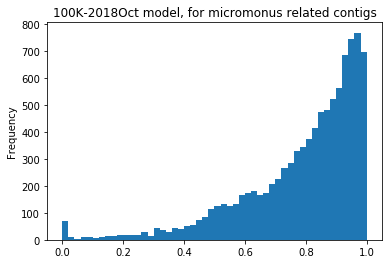

In [28]:
df_micromonus.new_prediction.plot.hist(bins=50, title='100K-2018Oct model, for micromonus related contigs')

### updated model with 100K segments sampled with new method 2018-April


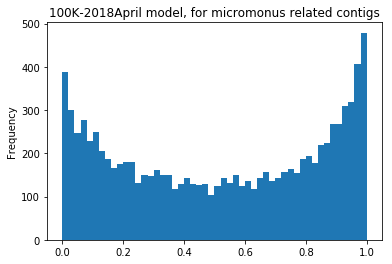

In [29]:
df_micromonus.old_prediction.plot.hist(bins=50, title='100K-2018April model, for micromonus related contigs')

## All TARA contigs, with updated model  using 100K training segments

Text(0, 0.5, 'number of contigs')

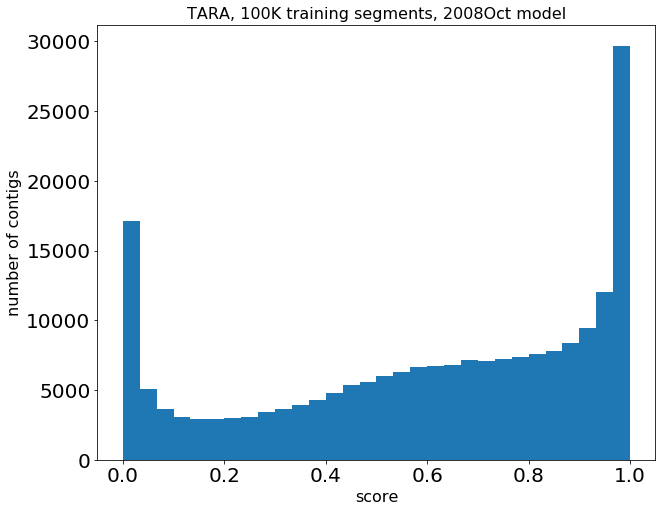

In [30]:
fig = plt.figure(figsize=(10,8))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [new_table_old_new_joined[new_table_old_new_joined['new_prediction']>0]['new_prediction']]
ax0.hist(x_multi, n_bins, histtype='bar')
ax0.set_title('TARA, 100K training segments, 2008Oct model',fontsize=16)
ax0.set_xlabel('score',fontsize=16)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=16)



## "nonvirus" TARA contigs, with updated model using 100K training segments 

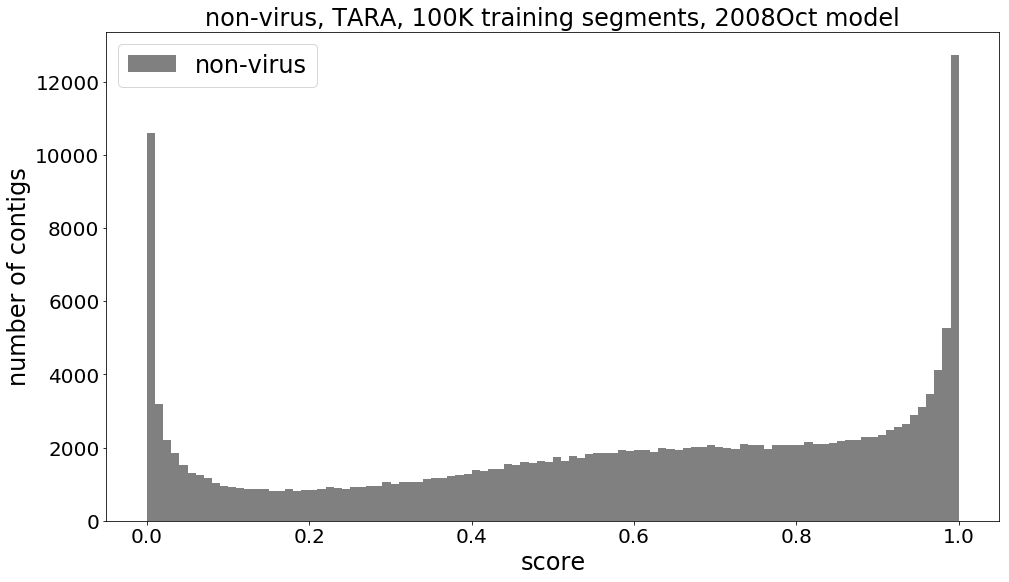

In [31]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 100
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus[df_nonvirus['new_prediction']>0]['new_prediction']]
ax0.hist(x_multi, n_bins, histtype='bar',  label=[
                                                  'non-virus'],
         color=['grey'])
ax0.set_title('non-virus, TARA, 100K training segments, 2008Oct model',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

## "virus" TARA contigs, with updated model using 100K training segments 

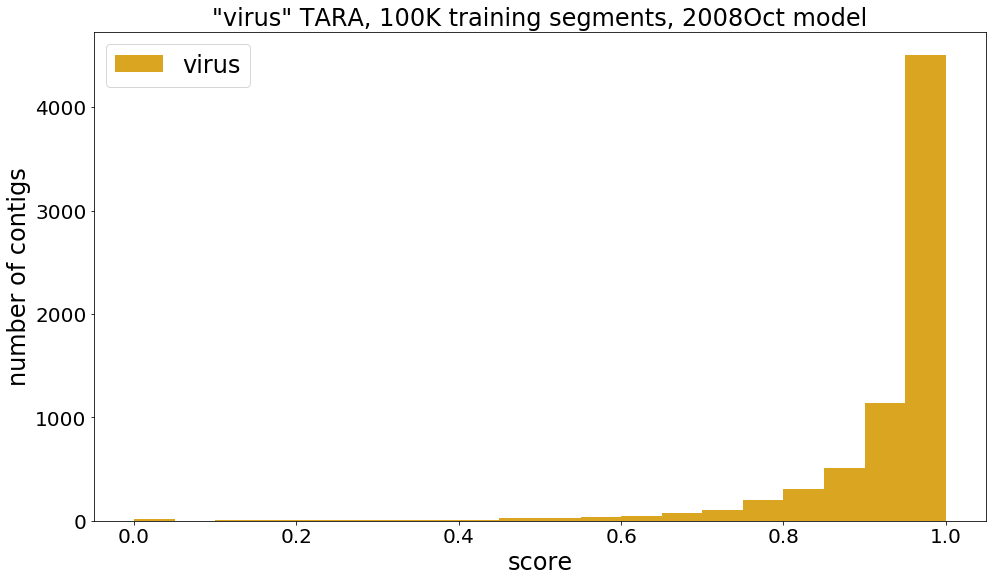

In [32]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 20
#colors = ['red', 'blue', 'grey']
x_multi = [df_virus[df_virus.new_prediction>0].new_prediction]
ax0.hist(x_multi, n_bins, histtype='bar',  label=[
                                                  'virus'],
         color=['goldenrod'])
ax0.set_title('"virus" TARA, 100K training segments, 2008Oct model',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

## Check the distribution of probability of same number of "virus", "non-virus", 'unknown" contigs

### Balanced data, same number of "virus" and "non-virus" contigs



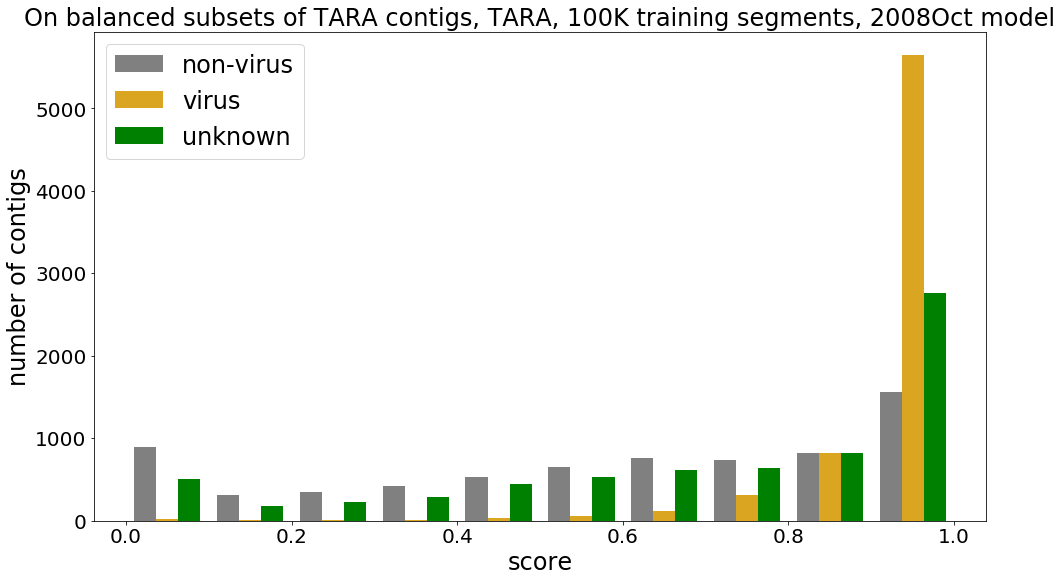

In [36]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.new_prediction,df_virus.new_prediction, df_unknown_subsample.new_prediction ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus','virus','unknown'],color=['grey', 'goldenrod', 'green'])
ax0.set_title('On balanced subsets of TARA contigs, TARA, 100K training segments, 2008Oct model',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})
fig.savefig("./balanced_data_TARA_100K_2018Oct.png")

## Balanced TARA contigs (same number of "virus" and "non-virus")

### comparing the updated model with 100K training segments and old model with 300K training segments

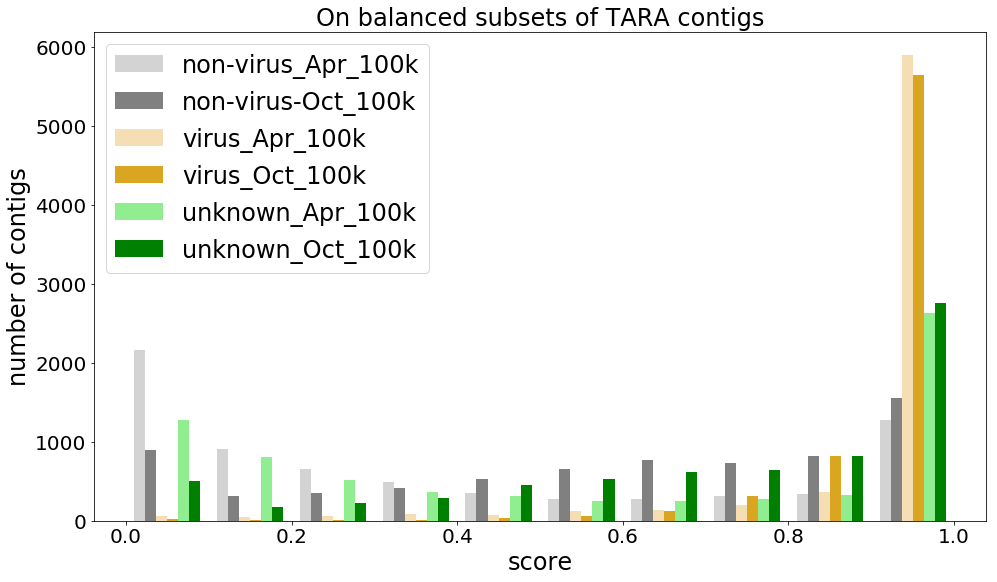

In [37]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample['old_prediction'],df_nonvirus_subsample.new_prediction,df_virus['old_prediction'],
           df_virus.new_prediction,df_unknown_subsample['old_prediction'],df_unknown_subsample.new_prediction ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus_Apr_100k','non-virus-Oct_100k',
                                                  'virus_Apr_100k','virus_Oct_100k',
                                                  'unknown_Apr_100k','unknown_Oct_100k'],
         color=['lightgrey','grey', 'wheat','goldenrod', 'lightgreen','green'])
ax0.set_title('On balanced subsets of TARA contigs',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.legend(prop={'size': 24})
fig.savefig("./balanced_data_TARA_100K_2018Oct_vs_2018Apr.png")